In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import scipy 

In [2]:
import networkx as nx

In [3]:
import os 

# Motivation

* A quality product is one that satisfies its specification. 
     - Addressed by the product engineers.
* A quality product is one that users are happy to work with.
     - Could be answered by surveying the product's users.
* A quality product is one that has lasted for a long time with minimal, if any, breaks. 
     - Could be answered by looking at bug fix rates/counts. 
* A quality product is one with observable properties that fall within a good interval of some quality standard. 
     - Could be answered by defining a standard with desirable properties, a tool for "observing" these properties, and analysing the resulting numbers. 

## Signature-Based Static Analysis

* In contrast to "learning-based," signature-based static analysis can be thought to be a collection of techniques for observing the structure of programs, which relies on a pre-defined database of patterns (or anti-patterns) against which judgments relating to the quality of the program being observed can be made. 

* One such "database of patterns" is the recently released "ISO/IEC 5055" International Standard for automated source code quality measures---measures which, according to the authors, "were calculated from detecting and counting violations of good architectural and coding practices in the source code that could result in unacceptable operational risks or excessive costs."

* This notebook presents a use case for a static analysis tool that is currently under development here at the University of Oregon for "detecting and counting violations" in coding practices as specified by the ISO/IEC 5055 standard. 

* Conformance: automated, objective, transparent, verifiable. 

## Why a New Tool? 

*Aren't tools that can do this type of thing already in abundance? What justification is there for trying to develop a new type of tool?* 

While it is true that there exists a not so small number of static analysis tools (see for example [this wikipedia article](https://en.wikipedia.org/wiki/List_of_tools_for_static_code_analysis)), most of them are, unfortunately, proprietary. Further, of those that are not proprietary and are still non-retired, only a small number support C/C++ codes. Finally, none of these tools claim to rely on the same ISO/IEC 5055 standard which we are targeting.



# The Tool : What Can It Do?

### The Gathered Data

Given a C/C++ repository which can be built using CMake, data related to various aspects of the standard can be gathered with `/static/driver/main.py --init --all`. The following loads that data so we can look at how it is structured:

In [4]:
logs_path     = "logs/hypre"
version_paths = []
for path in os.listdir(logs_path): 
    print(path)
    version_paths.append(path)

v2.22.0
v2.22.1
v2.19.0
v2.13.0
v2.17.0
v2.11.2
v2.21.0
v2.18.2
v2.14.0
v2.20.0
v2.24.0
v2.11.0
v2.15.1
v2.11.1
v2.15.0
v2.23.0
v2.12.0
v2.18.0
v2.16.0
v2.18.1
v2.12.1


In [5]:
test_version_path = '/'.join([logs_path, "v2.24.0", ".quality-uo"]) 
for path in os.listdir(test_version_path): 
    print(path)

hypre-ast-metrics
hypre-qmetrics
hypre-cgmetrics.csv
hypre-ll
hypre-callgraph
hypre-pp-metrics
hypre-funcnames.txt
hypre-callgraph.TabOne
hypre-qmetrics.csv


In [37]:
test_q_metrics_path = '/'.join([test_version_path, "hypre-qmetrics"]) 
for path in os.listdir(test_q_metrics_path): 
    if os.path.isdir(path):
        print(path)

In [6]:
test_ast_metrics_path = '/'.join([test_version_path, "hypre-ast-metrics"])
for path in os.listdir(test_ast_metrics_path): 
    print(path)

cwe-1087-cls-vrt-no-vrt-dstrctr
cwe-1055
visit-switch
goto-out-of-switch
cwe-1079-parcls-no-vrt-dstrctr


In [7]:
test_visit_switch = '/'.join([test_ast_metrics_path, "visit-switch"]) 
for path in os.listdir(test_visit_switch): 
    print(path)

_hypre_src_struct_ls_red_black_constantcoef_gs_metrics.csv
_hypre_src_struct_ls_sparse_msg2_setup_rap_metrics.csv
_hypre_src_parcsr_ls_par_nodal_systems_metrics.csv
_hypre_src_struct_ls_semi_restrict_metrics.csv
_hypre_src_struct_mv_communication_info_metrics.csv
_hypre_src_parcsr_block_mv_csr_block_matrix_metrics.csv
_hypre_src_sstruct_ls_HYPRE_sstruct_split_metrics.csv
_hypre_src_struct_ls_cyclic_reduction_metrics.csv
_hypre_src_parcsr_ls_par_cheby_metrics.csv
_hypre_src_struct_ls_pfmg_setup_interp_metrics.csv
_hypre_src_struct_ls_semi_setup_rap_metrics.csv
_hypre_src_struct_ls_sparse_msg_interp_metrics.csv
_hypre_src_struct_ls_smg2_setup_rap_metrics.csv
_hypre_src_parcsr_ls_ams_metrics.csv
_hypre_src_struct_ls_red_black_gs_metrics.csv
_hypre_src_struct_ls_smg_residual_metrics.csv
_hypre_src_struct_ls_smg_setup_rap_metrics.csv
_hypre_src_sstruct_ls_node_relax_metrics.csv
_hypre_src_parcsr_ls_par_amg_solveT_metrics.csv
_hypre_src_parcsr_ls_par_cr_metrics.csv
_hypre_src_parcsr_ls_par_a

In [8]:
data = {v : {} for v in version_paths} 
data_version_paths = ['/'.join([logs_path, v, ".quality-uo"]) for v in version_paths]
for dvp, v in zip(data_version_paths, version_paths): 
    qmetrics_path_p  = '/'.join([dvp, "hypre-qmetrics.csv"]) 
    callgraph_path_p = '/'.join([dvp, "hypre-callgraph.TabOne"]) 
    funcnames_path_p = '/'.join([dvp, "hypre-funcnames.txt"]) 
    cgmetrics_path_p = '/'.join([dvp, "hypre-cgmetrics.csv"]) 
    
    data[v]["qmetrics"]  = pd.read_csv(qmetrics_path_p)
    data[v]["callgraph"] = nx.read_edgelist(callgraph_path_p, create_using=nx.DiGraph) 
    funcnames_v = []
    with open(funcnames_path_p, 'r') as fnames_reader: 
        funcnames_v = fnames_reader.readlines() 
    data[v]["funcnames"]        = pd.DataFrame(funcnames_v)
    data[v]["cgmetrics_path_p"] = pd.read_csv(cgmetrics_path_p)
    
    data[v]["ast_metrics"] = {}
    
    ast_metrics = os.listdir('/'.join([dvp, "hypre-ast-metrics"]))
    ast_metrics_path_ps = ['/'.join([dvp, "hypre-ast-metrics", metric]) for metric in ast_metrics]
    for ast_m_path, metric in zip(ast_metrics_path_ps, ast_metrics): 
        m_path_file = '/'.join([dvp, "hypre-ast-metrics", metric, "hypre" + "-" + metric + ".csv"])
        if os.stat(m_path_file).st_size != 0:
            if metric == "visit-switch":
                data[v]["ast_metrics"][metric] = pd.read_csv(m_path_file, names=["Message", "Location"])
    

In [9]:
data["v2.24.0"]["qmetrics"].head()

,Name,ArgCount,InstrCount,UniqVals,UniqOps,TotalOps,CC
0,Axpy,4 4 4 4,0 18 0 18,0 0 0 0,0 1075871752 0 1075871752,0 1075871752 0 1075871752,1 3 1 3
1,ComputeValuesNonsym,4,325,0,0,0,21
2,ComputeValuesSym,5,277,0,0,0,23
3,CopyVec,3 3 3 3,0 15 0 15,0 0 0 0,0 32776 0 32776,0 32776 0 32776,1 3 1 3
4,DiagScaleCreate,2 2,311 0,0 0,8388608 0,143130624 0,22 1


In [10]:
data["v2.24.0"]["callgraph"]

In [11]:
data["v2.24.0"]["funcnames"].head()

,0
0,hypre_dsygst\n
1,hypre_lapack_lsame\n
2,hypre_lapack_xerbla\n
3,hypre_ilaenv\n
4,hypre_dsygs2\n


In [12]:
data["v2.24.0"]["cgmetrics_path_p"].head()

,Unnamed: 0,Name,FanIn,FanOut,IsIsolated,AvgShortestPath,Closeness,Betweenness,Eccentricity_R,Eccentricity_N
0,0,hypre_dsygst,1,8,False,549.888000,0.001819,10.0,6,983
1,1,hypre_lapack_lsame,15,0,False,inf,0.000000,0.0,0,1
2,2,hypre_lapack_xerbla,15,1,False,1267.916667,0.000789,258.0,5,983
3,3,hypre_ilaenv,11,3,False,1790.000000,0.000559,99.0,1,3940
4,4,hypre_dsygs2,1,0,False,inf,0.000000,0.0,0,4


### Example Checks

A number of these can be reported by the tool with the report flag. e.g: `/static/driver/main.py --report --metric CC --excess` will print those functions with an excessive cyclomatic complexity value.

#### Omitted Break in Switch Clause 

In [13]:
df = data["v2.24.0"]["ast_metrics"]["visit-switch"] 
df = df.loc[df.Message == "CASE MISSING BREAK"]
df.head()

,Message,Location
0,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg3_setup_rap.c:...
1,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg3_setup_rap.c:...
2,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg3_setup_rap.c:...
3,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg3_setup_rap.c:...
4,CASE MISSING BREAK,/hypre/src/parcsr_ls/par_cheby.c:119:10


In [14]:
df.size

308

#### Missing Default in Switch

In [15]:
df = data["v2.24.0"]["ast_metrics"]["visit-switch"]
df = df.loc[df.Message == "SWITCH MISSING DEFAULT"]
df.head()

,Message,Location
7,SWITCH MISSING DEFAULT,/hypre/src/parcsr_ls/par_cheby.c:111:7
11,SWITCH MISSING DEFAULT,/hypre/src/parcsr_ls/par_cheby.c:154:7
22,SWITCH MISSING DEFAULT,/hypre/src/utilities/printf.c:52:10
25,SWITCH MISSING DEFAULT,/hypre/src/struct_ls/smg_relax.c:283:7
26,SWITCH MISSING DEFAULT,/hypre/src/sstruct_ls/node_relax.c:418:13


In [16]:
df.size

154

#### Callable with Excessive Number of Parameters

In [17]:
def qmetrics_column_func(x, frame): 
    '''
    Given row entry *x* of dataframe *frame*, 
    return *x* if it's an 'int', otherwise 
    make sure it's a space separated string 
    of concatenated ints, and return the largest 
    of these. 

    (i.e since *frame* is grouped by function name, 
    metrics for the same function occuring in multiple 
    files may be grouped together, creating these 
    strings.)

    Keyword arguments: 
    x     -- row entry of pandas dataframe 
    frame -- pandas dataframe to process.
    '''
    if isinstance(x, int): 
        return x 
    else: 
        return max([int(s) if (s != 'VARGS') 
                           and not (s in frame.columns)
                        else 0 for s in x.strip().split()
                 ])



def prep_qmetrics(frame): 
    '''
    Prepare quality metrics dataframe *fname* for processing 
    and return it. 

    Keyword arguments: 

    frame    -- Pandas dataframe containing structural code quality metrics. 
    '''
    for c in frame.columns: 
        if c != 'Name': 
            frame[c] = frame[c].apply(lambda x : qmetrics_column_func(x, frame))
    return frame 

In [18]:
MAX_ARGS = 7
df = prep_qmetrics(data["v2.24.0"]["qmetrics"])
df = df.loc[df.ArgCount >= MAX_ARGS]
df = df.drop(columns=["UniqVals", "UniqOps", "TotalOps"])
df.head()

,Name,ArgCount,InstrCount,CC
33,FGMRES_ParaSails,7,486,18
37,Factor_dhInit,7,142,10
52,GenerateCoordinates,11,135,12
54,GenerateDifConv,11,621,44
55,GenerateLaplacian,11,733,44


#### Large Number of Outward Calls

In [19]:
from distfit import distfit

In [20]:
dist = distfit()
X    = data["v2.24.0"]["cgmetrics_path_p"].FanOut
dist.fit_transform(X)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0345981] [loc=2.493 scale=5.126]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0032189] [loc=0.000 scale=2.493]
[distfit] >[pareto    ] [0.13 sec] [RSS: 0.0058327] [loc=-2.659 scale=2.659]
[distfit] >[dweibull  ] [0.08 sec] [RSS: 0.0151845] [loc=1.000 scale=1.141]
[distfit] >[t         ] [0.08 sec] [RSS: 0.0652023] [loc=1.000 scale=0.000]
[distfit] >[genextreme] [0.10 sec] [RSS: 0.0029625] [loc=0.753 scale=0.928]
[distfit] >[gamma     ] [0.12 sec] [RSS: 0.0599536] [loc=-0.000 scale=1.562]
[distfit] >[lognorm   ] [0.05 sec] [RSS: 0.0092057] [loc=-0.091 scale=1.101]
[distfit] >[beta      ] [0.19 sec] [RSS: 0.0147876] [loc=-0.000 scale=1085.630]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0633433] [loc=0.000 scale=164.000]
[distfit] >[loggamma  ] [0.12 sec] [RSS: 0.0369103] [loc=-2153.108 scale=276.614]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.genextreme_gen at 0x7fe89a7fd7c0>,
  'stats': 'RSS',
  'params': (-0.6114960356000514, 0.7525175667191945, 0.9278829569638545),
  'name': 'genextreme',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fe89822ff10>,
  'score': 0.0029625227864957396,
  'loc': 0.7525175667191945,
  'scale': 0.9278829569638545,
  'arg': (-0.6114960356000514,),
  'CII_min_alpha': 0.010865969199187364,
  'CII_max_alpha': 8.565350179010126},
 'summary':          distr       score  LLE          loc        scale  \
 0   genextreme  0.00296252  NaN     0.752518     0.927883   
 1        expon  0.00321893  NaN            0       2.4932   
 2       pareto  0.00583266  NaN     -2.65918      2.65918   
 3      lognorm   0.0092057  NaN   -0.0910203      1.10109   
 4         beta   0.0147876  NaN -4.29726e-27      1085.63   
 5     dweibull   0.0151845  NaN            1      1.14101   
 6         norm   0.0345981  NaN       2.4932      5.12558   
 7    

In [28]:
high = dist.model['CII_max_alpha']

In [29]:
low = dist.model['CII_min_alpha']

In [30]:
high

8.565350179010126

In [31]:
low

0.010865969199187364

In [32]:
high_d     = data["v2.24.0"]["cgmetrics_path_p"][X > high]
high_d.head()

,Unnamed: 0,Name,FanIn,FanOut,IsIsolated,AvgShortestPath,Closeness,Betweenness,Eccentricity_R,Eccentricity_N
19,19,hypre_ParCSRCommPkgCreate_core,3,9,False,382.239583,0.002616,54.000000,3,3077
51,51,hypre_BoomerAMGBlockRelax,1,16,False,148.989298,0.006712,308.133333,5,1047
57,57,hypre_ParCSRBlockMatrixConvertToParCSRMatrix,1,10,False,341.926531,0.002925,111.000000,5,3077
58,58,hypre_ParCSRMatrixToCSRMatrixAll,5,17,False,193.082948,0.005179,698.011111,4,479
59,59,hypre_ParVectorToVectorAll,5,14,False,223.656810,0.004471,460.577778,5,479


In [33]:
high_d.tail()

,Unnamed: 0,Name,FanIn,FanOut,IsIsolated,AvgShortestPath,Closeness,Betweenness,Eccentricity_R,Eccentricity_N
5181,5181,hypre_NodeRelaxSetup,1,18,False,172.007812,0.005814,99.346753,5,479
5210,5210,hypre_PFMGSetup,1,39,False,59.384748,0.016839,704.480952,6,3469
5255,5255,hypre_Maxwell_PNedelec,1,33,False,133.102888,0.007513,9.800000,6,1044
5301,5301,FGMRES_ParaSails,0,12,False,328.775510,0.003042,0.000000,3,479
5319,5319,SubdomainGraph_dhExchangePerms,1,12,False,344.803805,0.002900,24.342857,4,983


#### Excessive CC value

In [62]:
dist = distfit()
X    = prep_qmetrics(data["v2.24.0"]["qmetrics"]).CC
X.drop(columns=["UniqVals", "UniqOps", "TotalOps"])
dist.fit_transform(X)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0018760] [loc=7.603 scale=26.219]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0001168] [loc=0.000 scale=7.603]
[distfit] >[pareto    ] [0.08 sec] [RSS: 0.0014235] [loc=-2.160 scale=2.160]
[distfit] >[dweibull  ] [0.15 sec] [RSS: 0.0024107] [loc=1.000 scale=1.759]
[distfit] >[t         ] [0.08 sec] [RSS: 0.0032524] [loc=1.000 scale=0.000]
[distfit] >[genextreme] [0.16 sec] [RSS: 0.0018271] [loc=1.342 scale=1.006]
[distfit] >[gamma     ] [0.10 sec] [RSS: 0.0032353] [loc=-0.000 scale=3.071]
[distfit] >[lognorm   ] [0.06 sec] [RSS: 0.0011022] [loc=-0.002 scale=2.184]
[distfit] >[beta      ] [0.18 sec] [RSS: 0.0006939] [loc=-0.000 scale=7303.290]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0031723] [loc=0.000 scale=790.000]
[distfit] >[loggamma  ] [0.11 sec] [RSS: 0.0024606] [loc=-636.668 scale=211.652]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.expon_gen at 0x7fe89a7d3250>,
  'stats': 'RSS',
  'params': (0.0, 7.603373231773667),
  'name': 'expon',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fe89e83f370>,
  'score': 0.00011681693215105001,
  'loc': 0.0,
  'scale': 7.603373231773667,
  'arg': (),
  'CII_min_alpha': 0.39000206151578826,
  'CII_max_alpha': 22.777670578300878},
 'summary':          distr        score  LLE          loc        scale  \
 0        expon  0.000116817  NaN            0      7.60337   
 1         beta  0.000693893  NaN -2.07522e-24      7303.29   
 2      lognorm    0.0011022  NaN  -0.00169813      2.18425   
 3       pareto    0.0014235  NaN     -2.15957      2.15957   
 4   genextreme   0.00182712  NaN      1.34196      1.00571   
 5         norm   0.00187595  NaN      7.60337      26.2186   
 6     dweibull   0.00241073  NaN            1        1.759   
 7     loggamma   0.00246056  NaN     -636.668      211.652   
 8      uniform  

In [63]:
high = dist.model['CII_max_alpha']
high_d = prep_qmetrics(data["v2.24.0"]["qmetrics"]).drop(columns=["UniqVals", "UniqOps", "TotalOps"])[X > high]
high_d.head()

,Name,ArgCount,InstrCount,CC
2,ComputeValuesSym,5,277,23
17,Euclid_dhDestroy,1,138,23
25,Euclid_dhSetup,1,310,35
28,ExternalRows_dhDestroy,1,147,25
31,ExternalRows_dhRecvRows,1,385,41


In [64]:
print(high)

22.777670578300878


### Project Growth

#### Total CC

In [38]:
sorted_versions = ["v2.24.0", "v2.23.0", "v2.22.1", "v2.22.0"
                            , "v2.21.0", "v2.20.0", "v2.19.0"
                            , "v2.18.2", "v2.18.1", "v2.18.0"
                            , "v2.17.0", "v2.16.0", "v2.15.1"
                            , "v2.15.0", "v2.14.0", "v2.13.0"
                            , "v2.12.1", "v2.12.0", "v2.11.2"
                            , "v2.11.1", "v2.11.0"][::-1]


Text(0.5, 1.0, 'Hypre Cyclomatic Complexity Trends')

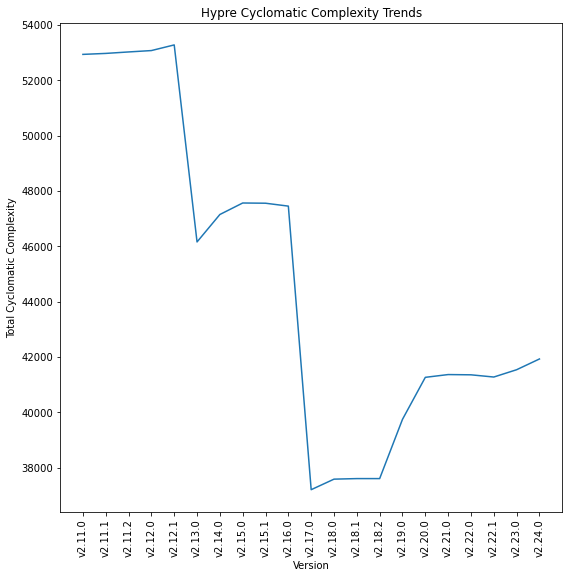

In [45]:
total_ccs = [] 
for version in sorted_versions: 
    df = prep_qmetrics(data[version]["qmetrics"])
    df = df.drop(columns=["UniqVals", "UniqOps", "TotalOps"]) 
    tt_cc = df.CC.sum() 
    total_ccs.append(tt_cc)

plt.figure(figsize=(9, 9))
plt.plot(sorted_versions, total_ccs)
plt.xticks(rotation=90)
plt.xlabel("Version")
plt.ylabel("Total Cyclomatic Complexity")
plt.title("Hypre Cyclomatic Complexity Trends")

#### Total Functions

In [48]:
data["v2.24.0"]["funcnames"].size

5371

Text(0.5, 1.0, 'Hypre Total Number of Functions Trend')

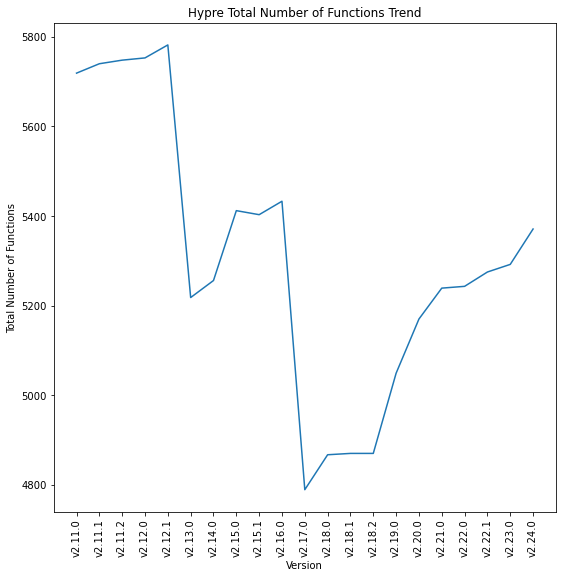

In [50]:
total_fs = [] 
for version in sorted_versions: 
    size = data[version]["funcnames"].size
    total_fs.append(size)

plt.figure(figsize=(9, 9))
plt.plot(sorted_versions, total_fs)
plt.xticks(rotation=90)
plt.xlabel("Version")
plt.ylabel("Total Number of Functions")
plt.title("Hypre Total Number of Functions Trend")

#### Eccentricity

Text(0.5, 1.0, 'Hypre Callgraph Diameter Trends')

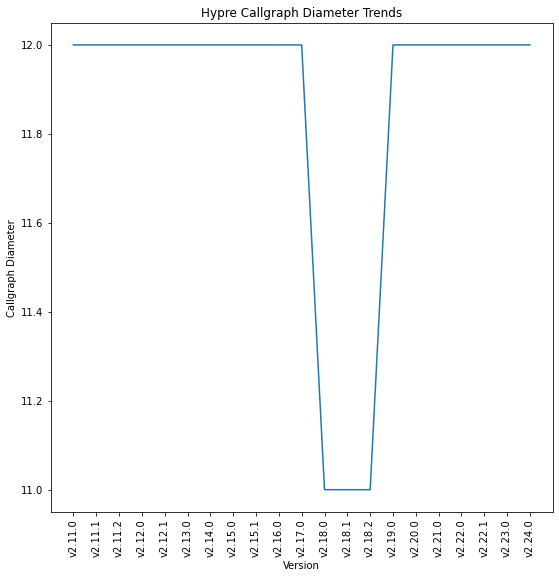

In [53]:
total_ecc = [] 
for version in sorted_versions: 
    df = data[version]["cgmetrics_path_p"]
    tt_ecc = df.Eccentricity_R.max() 
    total_ecc.append(tt_ecc)

plt.figure(figsize=(9, 9))
plt.plot(sorted_versions, total_ecc)
plt.xticks(rotation=90)
plt.xlabel("Version")
plt.ylabel("Callgraph Diameter")
plt.title("Hypre Callgraph Diameter Trends")

#### Total FanOut

Text(0.5, 1.0, 'Hypre Function Call Trends')

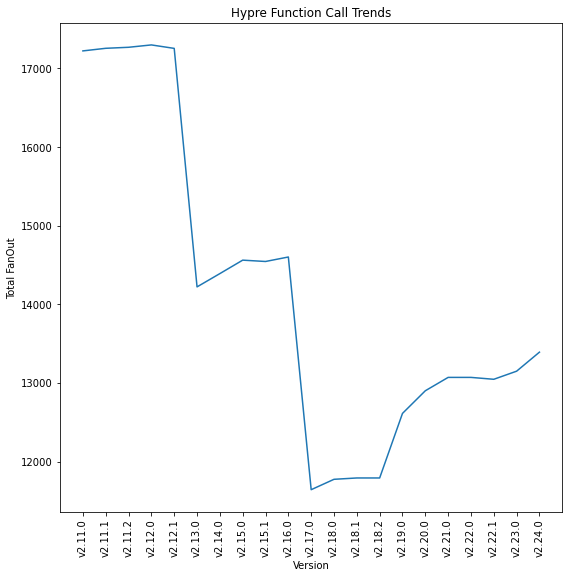

In [58]:
total_fanout = [] 
for version in sorted_versions: 
    df = data[version]["cgmetrics_path_p"]
    fanout = df.FanOut.sum() 
    total_fanout.append(fanout)

plt.figure(figsize=(9, 9))
plt.plot(sorted_versions, total_fanout)
plt.xticks(rotation=90)
plt.xlabel("Version")
plt.ylabel("Total FanOut")
plt.title("Hypre Function Call Trends")

#### Total Instructions in LLVM IR

Text(0.5, 1.0, 'Hypre Cyclomatic Complexity Trends')

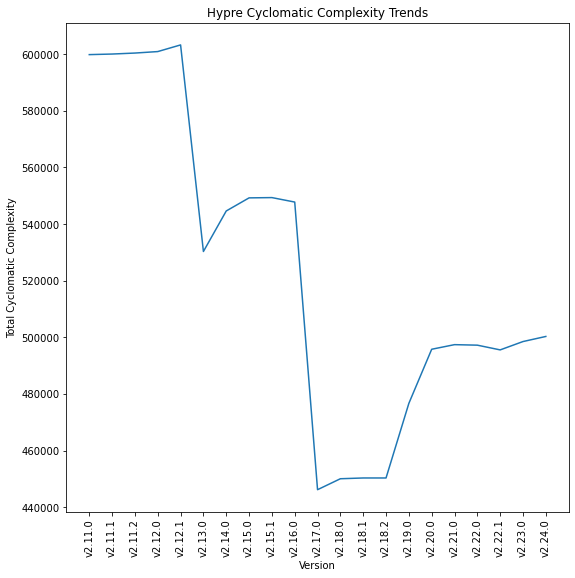

In [65]:
total_instrs = [] 
for version in sorted_versions: 
    df = prep_qmetrics(data[version]["qmetrics"])
    df = df.drop(columns=["UniqVals", "UniqOps", "TotalOps"]) 
    tt_instrs = df.InstrCount.sum() 
    total_instrs.append(tt_instrs)

plt.figure(figsize=(9, 9))
plt.plot(sorted_versions, total_instrs)
plt.xticks(rotation=90)
plt.xlabel("Version")
plt.ylabel("Total Cyclomatic Complexity")
plt.title("Hypre Cyclomatic Complexity Trends")

### Smell Trends

#### Total Missing Default in Switch

Text(0.5, 1.0, 'Hypre Missing Default in Switch Trends')

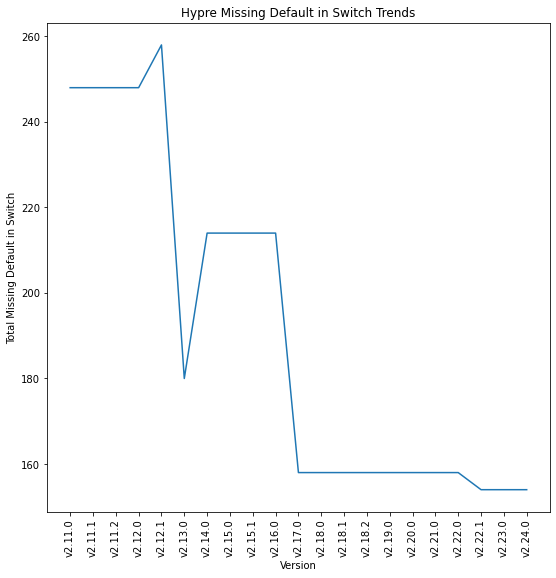

In [67]:
df = data["v2.24.0"]["ast_metrics"]["visit-switch"]
df = df.loc[df.Message == "SWITCH MISSING DEFAULT"]
df.head()

total_switch_miss = [] 
for version in sorted_versions: 
    df = data[version]["ast_metrics"]["visit-switch"] 
    df = df.loc[df.Message == "SWITCH MISSING DEFAULT"] 
    total_switch_miss.append(df.size)
plt.figure(figsize=(9, 9))
plt.plot(sorted_versions, total_switch_miss)
plt.xticks(rotation=90)
plt.xlabel("Version")
plt.ylabel("Total Missing Default in Switch")
plt.title("Hypre Missing Default in Switch Trends")

#### Total Case Clauses Missing Break

Text(0.5, 1.0, 'Hypre Total Cases Missing Break Trends')

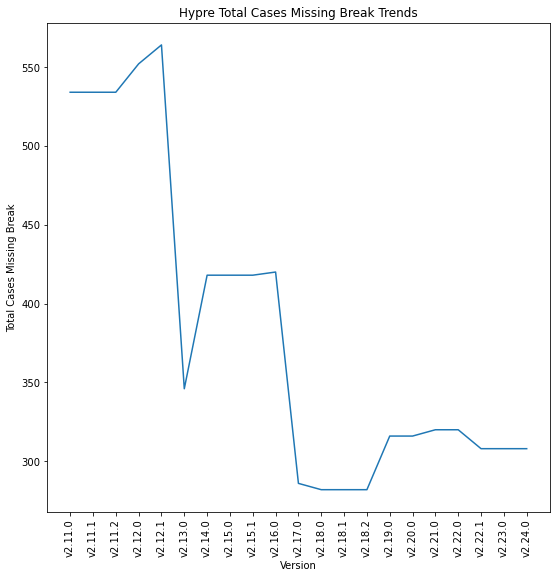

In [68]:
df = data["v2.24.0"]["ast_metrics"]["visit-switch"] 
df = df.loc[df.Message == "CASE MISSING BREAK"]
df.head()

total_cases = [] 
for version in sorted_versions: 
    df = data[version]["ast_metrics"]["visit-switch"]
    df = df.loc[df.Message == "CASE MISSING BREAK"] 
    total_cases.append(df.size)
plt.figure(figsize=(9, 9))
plt.plot(sorted_versions, total_cases)
plt.xticks(rotation=90)
plt.xlabel("Version")
plt.ylabel("Total Cases Missing Break")
plt.title("Hypre Total Cases Missing Break Trends")   

In [73]:
df = data["v2.24.0"]["ast_metrics"]["visit-switch"]

In [74]:
df

,Message,Location
0,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg3_setup_rap.c:...
1,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg3_setup_rap.c:...
2,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg3_setup_rap.c:...
3,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg3_setup_rap.c:...
4,CASE MISSING BREAK,/hypre/src/parcsr_ls/par_cheby.c:119:10
...,...,...
226,SWITCH MISSING DEFAULT,/hypre/src/sstruct_mv/HYPRE_sstruct_graph.c:4...
227,SWITCH MISSING DEFAULT,/hypre/src/struct_ls/sparse_msg_setup_rap.c:34:4
228,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg_setup_rap.c:74:7
229,CASE MISSING BREAK,/hypre/src/struct_ls/sparse_msg_setup_rap.c:91:7


In [71]:
data.keys()

dict_keys(['v2.22.0', 'v2.22.1', 'v2.19.0', 'v2.13.0', 'v2.17.0', 'v2.11.2', 'v2.21.0', 'v2.18.2', 'v2.14.0', 'v2.20.0', 'v2.24.0', 'v2.11.0', 'v2.15.1', 'v2.11.1', 'v2.15.0', 'v2.23.0', 'v2.12.0', 'v2.18.0', 'v2.16.0', 'v2.18.1', 'v2.12.1'])

In [72]:
data["v2.24.0"]

{'qmetrics':                              Name  ArgCount  InstrCount  UniqVals     UniqOps  \
 0                            Axpy         4          18         0  1075871752   
 1             ComputeValuesNonsym         4         325         0           0   
 2                ComputeValuesSym         5         277         0           0   
 3                         CopyVec         3          15         0       32776   
 4                 DiagScaleCreate         2         311         0     8388608   
 ...                           ...       ...         ...       ...         ...   
 5509  utilities_FortranMatrixWrap         5          22         0           0   
 5510                     vfprintf         3           0         0           0   
 5511                     vsprintf         3           0         0           0   
 5512                     writeMat         3          44         0   268435520   
 5513                     writeVec         3          38         0   268435520   
 
  